# 50.039 Theory and Practice of Deep Learning | Coding Homework 3 - Fully Connected Network Exercise
## Joel Huang, 1002530

Note: some of the main code is written in separate files, but imported as Python modules.
* The model architecture is in `./model`
* Data loaders, metrics and visualization code is in `./utils`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model.model import FCN
from utils.data_loaders import get_data_loaders
from utils.scoring import get_classwise_accuracy
from utils.visualization import plot_training_validation_loss
from utils.visualization import plot_classwise_accuracies

## Define train, validation and test sequences

In [2]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = torch.mean(torch.tensor(train_losses))
    print('\nEpoch: {}'.format(epoch))
    print('Training set: Average loss: {:.4f}'.format(train_loss))
    
    return train_loss

def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # sum up all the batch losses
            val_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # get the average validation loss
    val_loss /= len(val_loader.dataset)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    return val_loss

def test(model, device, test_loader):
    model.eval()
    
    num_classes = 10
    outputs = []
    classes = []
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for _, (input_batch, class_list) in enumerate(test_loader):
            input_batch, class_list = input_batch.to(device), class_list.to(device)
            output = model(input_batch)
            _, preds = torch.max(output, 1)
            for t, p in zip(class_list.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
           
    classwise_accuracy = get_classwise_accuracy(confusion_matrix)
    
    return classwise_accuracy

## Run pipeline

In [3]:
DATA_DIRECTORY = 'data/'
use_cuda = 1
batch_size = 32
num_epochs = 10
learning_rate = 1e-2

train_loader, test_loader = get_data_loaders(batch_size, DATA_DIRECTORY)
device = torch.device("cuda" if use_cuda else "cpu")
model = FCN().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    val_loss = validate(model, device, test_loader) # use test as val (wrong)

    if (len(val_losses) > 0) and (val_loss < min(val_losses)):
        torch.save(model.state_dict(), "fashion_mnist_fcn.pt")
        print("Saving model (epoch {}) with lowest validation loss: {}"
              .format(epoch, val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

print("Training and validation complete.")

print("Loading model for inference.")
model.load_state_dict(torch.load("fashion_mnist_fcn.pt"))

print("Running inference.")
classwise_accuracies = test(model, device, test_loader)

/home/joel/Desktop/deep-learning-theory-practice/hw3-coding-fcn/model/model.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Epoch: 1
Training set: Average loss: 1.0854
Validation set: Average loss: 0.6632, Accuracy: 45821/60000 (76%)

Epoch: 2
Training set: Average loss: 0.5801
Validation set: Average loss: 0.5147, Accuracy: 49347/60000 (82%)
Saving model (epoch 2) with lowest validation loss: 0.51472947965463

Epoch: 3
Training set: Average loss: 0.4978
Validation set: Average loss: 0.4883, Accuracy: 49797/60000 (83%)
Saving model (epoch 3) with lowest validation loss: 0.4883463346083959

Epoch: 4
Training set: Average loss: 0.4617
Validation set: Average loss: 0.4582, Accuracy: 50346/60000 (84%)
Saving model (epoch 4) with lowest validation loss: 0.45816672285397847

Epoch: 5
Training set: Average loss: 0.4383
Validation set: Average loss: 0.4182, Accuracy: 51249/60000 (85%)
Saving model (epoch 5) with lowest validation loss: 0.41820165537993115

Epoch: 6
Training set: Average loss: 0.4198
Validation set: Average loss: 0.4036, Accuracy: 51538/60000 (86%)
Saving model (epoch 6) with lowest validation loss

## Training and validation loss

Training and validation loss are decreasing, with slight signs of underfitting, as the loss values are pretty similar. We can afford to make the model more complex, in which case we would expect to see validation loss slightly higher than training loss but still decreasing along with it.

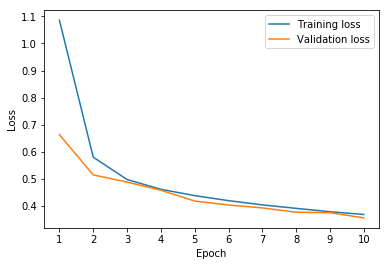

In [4]:
plot_training_validation_loss(num_epochs, train_losses, val_losses)

## Classwise accuracy

Here we enumerate the `test_loader` again, recalculating the confusion matrix based on the predicted and true labels. Based on the following scores, the hardest class to predict seems to be class 6 (shirts)

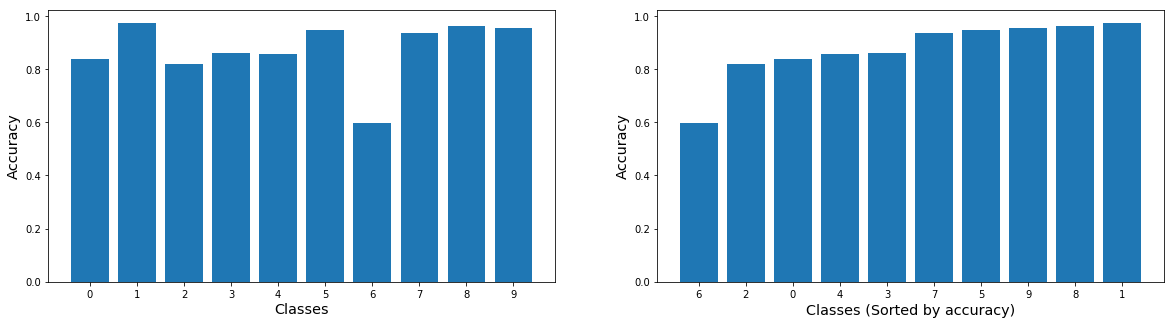

In [5]:
plot_classwise_accuracies(classwise_accuracies)

## Best accuracy over all classes

Best accuracy is calculated as the average of the classwise accuracies.

In [6]:
best_accuracy = torch.mean(classwise_accuracies)
print('Test set: Best accuracy: {}'.format(best_accuracy))

Test set: Best accuracy: 0.8746999502182007


## Learning Points
* Use `transforms.ToTensor()` to convert a PIL image to `torch.tensor`. You can feed a list of transforms to the `DataLoader`.
* When building the model, for an input tensor with shape `(d1, ..., dn)`, you input a tensor of shape `(batch_size, d1, ..., dn)` by using `tensor.view()` to reshape the raw tensor, which might not be in this shape. You can do this either outside the model class, or as part of the `forward()` implementation, similar to `flatten` layers in Keras or Tensorflow.
 * In this case we had a `tensor` of shape `(32, 1, 28, 28)`. This was reshaped to `(32, 784)` using `tensor.view()` before it can be used as an input to layer `FCN.fc1` which maps from an input of `784` to an output of `300`.
